In [8]:
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from transformers import BertTokenizer
from torchvision import transforms
from sklearn.model_selection import train_test_split  # 导入 train_test_split

class MultimodalDataset(Dataset):
    def __init__(self, image_dir, text_dir, annotations_file, tokenizer, transform=None, mode='train'):
        self.image_dir = image_dir
        self.text_dir = text_dir
        self.transform = transform if transform else transforms.ToTensor()  # 默认使用 ToTensor 转换
        self.tokenizer = tokenizer
        self.mode = mode  # 'train' 或 'val'
        
        # 标签映射字典
        self.label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
        
        with open(annotations_file, 'r') as f:
            # 跳过第一行标题，并读取其余内容
            lines = f.readlines()[1:]  # 跳过第一行
            self.data = [line.strip().split(',') for line in lines]
                
        # 将数据划分为训练集和验证集
        self.train_data, self.val_data = train_test_split(self.data, test_size=0.2, random_state=42)
    
    def __len__(self):
        # 根据 mode 来选择加载训练集或验证集
        if self.mode == 'train':
            return len(self.train_data)
        else:
            return len(self.val_data)
    
    def __getitem__(self, idx):
        # 根据 mode 来选择使用训练集或验证集
        data = self.train_data if self.mode == 'train' else self.val_data
        guid, label = data[idx]  # 获取 guid 和对应的标签
        image = Image.open(os.path.join(self.image_dir, f"{guid}.jpg"))
        
        # 尝试用不同的编码打开文本文件，防止出现解码错误
        text = ""
        try:
            with open(os.path.join(self.text_dir, f"{guid}.txt"), 'r', encoding='utf-8') as f:
                text = f.read().strip()
        except UnicodeDecodeError:
            # 如果 utf-8 解码失败，尝试使用 latin1 编码
            with open(os.path.join(self.text_dir, f"{guid}.txt"), 'r', encoding='latin1') as f:
                text = f.read().strip()
        
        if self.transform:
            image = self.transform(image)  # 转换图像为Tensor
        
        # 文本处理：tokenization
        text_tokens = self.tokenizer(text, padding="max_length", truncation=True, max_length=50, return_tensors="pt")
        
        # 使用标签映射字典将字符串标签转换为整数标签
        label = self.label_map[label]
        
        return {
            'image': image,
            'text': text_tokens,
            'label': torch.tensor(label)  # 标签：0, 1, 2 (negative, neutral, positive)
        }

# 创建数据集和数据加载器
image_dir = "./dataset/data"
text_dir = "./dataset/data"
annotations_file = "./dataset/train.txt"
tokenizer = BertTokenizer.from_pretrained("./bert_uncased")
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 例如，将图像大小调整为224x224
    transforms.ToTensor()  # 将图像转换为Tensor
])

# 创建训练数据集和验证数据集
train_dataset = MultimodalDataset(image_dir, text_dir, annotations_file, tokenizer, transform, mode='train')
val_dataset = MultimodalDataset(image_dir, text_dir, annotations_file, tokenizer, transform, mode='val')

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)  # 验证集通常不需要shuffle

In [9]:
import torch.nn as nn
import torchvision.models as models
from transformers import BertModel

class MultimodalModel(nn.Module):
    def __init__(self, num_classes=3):
        super(MultimodalModel, self).__init__()
        
        # 图像特征提取模型
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)  # 更新预训练权重的参数
        self.resnet.fc = nn.Identity()  # 去掉最后的分类层
        
        # 文本特征提取模型
        self.bert = BertModel.from_pretrained("./bert_uncased")
        
        # 融合后的全连接层，增加 Dropout 和 BatchNorm
        self.fc1 = nn.Linear(2048 + 768, 1024)  # 图像特征(2048) + 文本特征(768)
        self.batchnorm = nn.BatchNorm1d(1024)
        self.dropout = nn.Dropout(p=0.5)  # 添加 Dropout
        self.fc2 = nn.Linear(1024, 512)  # 隐藏层
        self.fc3 = nn.Linear(512, num_classes)  # 输出类别
        
    def forward(self, image, text_input):
        # 图像特征提取
        image_features = self.resnet(image)
        
        # 文本特征提取
        text_features = self.bert(**text_input).pooler_output
        
        # 融合图像和文本特征
        combined_features = torch.cat((image_features, text_features), dim=1)
        
        # 经过全连接层，BatchNorm，Dropout
        x = torch.relu(self.fc1(combined_features))
        x = self.batchnorm(x)  # BatchNorm 层
        x = self.dropout(x)    # Dropout 层
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [10]:
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt

# 创建模型
model = MultimodalModel(num_classes=3)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [11]:
def train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, num_epochs=10, device='cuda'):
    model.to(device)  # 将模型移动到指定设备
    
    train_losses = []  # 记录训练损失
    train_accuracies = []  # 记录训练准确率
    val_losses = []  # 记录验证损失
    val_accuracies = []  # 记录验证准确率
    
    for epoch in range(num_epochs):
        model.train()  # 设置模型为训练模式
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        
        for batch in train_loader:
            optimizer.zero_grad()
            
            # 获取数据并移动到设备
            images = batch['image'].to(device)
            texts = {key: value.squeeze(1).to(device) for key, value in batch['text'].items()}
            labels = batch['label'].to(device)
            
            # 模型前向传播
            outputs = model(images, texts)
            
            # 计算损失
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # 计算准确率
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
        
        # 计算并记录训练损失和准确率
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct_predictions / total_predictions
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
        
        # 训练后进行验证
        val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)
        
        # 记录验证集损失和准确率
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
    
    # 绘制损失和准确率曲线
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

In [12]:
# 修改评估函数，返回损失和准确率
def evaluate(model, val_loader, criterion, device):
    model.eval()  # 设置模型为评估模式
    correct_predictions = 0
    total_predictions = 0
    val_loss = 0.0
    
    with torch.no_grad():
        for batch in val_loader:
            # 获取验证数据并移动到设备
            images = batch['image'].to(device)
            texts = {key: value.squeeze(1).to(device) for key, value in batch['text'].items()}
            labels = batch['label'].to(device)
            
            # 模型前向传播
            outputs = model(images, texts)
            
            # 计算损失
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            # 计算准确率
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
    
    # 计算并返回验证损失和准确率
    avg_val_loss = val_loss / len(val_loader)
    accuracy = correct_predictions / total_predictions
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {accuracy:.4f}")
    return avg_val_loss, accuracy

In [13]:
# 绘制损失和准确率的曲线
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    # 绘制训练和验证损失
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # 绘制训练和验证准确率
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Val Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Epoch 1/10, Loss: 0.8554, Accuracy: 0.5984
Validation Loss: 0.7638, Validation Accuracy: 0.6700
Epoch 2/10, Loss: 0.5385, Accuracy: 0.7816
Validation Loss: 0.8705, Validation Accuracy: 0.6500
Epoch 3/10, Loss: 0.2600, Accuracy: 0.9137
Validation Loss: 1.0202, Validation Accuracy: 0.6562
Epoch 4/10, Loss: 0.1529, Accuracy: 0.9525
Validation Loss: 1.1860, Validation Accuracy: 0.6125
Epoch 5/10, Loss: 0.1165, Accuracy: 0.9656
Validation Loss: 1.2496, Validation Accuracy: 0.5962
Epoch 6/10, Loss: 0.0993, Accuracy: 0.9691
Validation Loss: 1.3204, Validation Accuracy: 0.6925
Epoch 7/10, Loss: 0.0993, Accuracy: 0.9691
Validation Loss: 1.2148, Validation Accuracy: 0.6388
Epoch 8/10, Loss: 0.0727, Accuracy: 0.9788
Validation Loss: 1.4416, Validation Accuracy: 0.5975
Epoch 9/10, Loss: 0.0526, Accuracy: 0.9819
Validation Loss: 1.5128, Validation Accuracy: 0.5950
Epoch 10/10, Loss: 0.1245, Accuracy: 0.9575
Validation Loss: 1.3065, Validation Accuracy: 0.6787


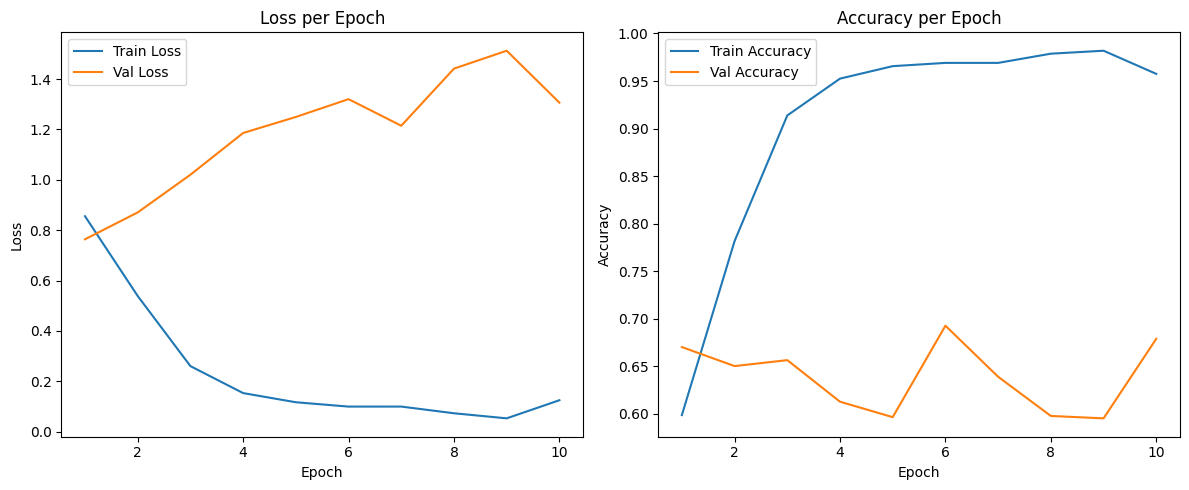

In [14]:
# 设置训练设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 开始训练和验证
train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, num_epochs=10, device=device)


In [15]:
import pandas as pd
from PIL import Image
import os
import torch

# 读取测试数据文件
test_file = "./dataset/test_without_label.txt"
df = pd.read_csv(test_file)

# 创建预测结果列表
predictions = []

# 对每一行进行预测
for idx, row in df.iterrows():
    guid = int(row['guid'])
    
    # 读取图像和文本
    image = Image.open(os.path.join("./dataset/data", f"{guid}.jpg"))
    try:
        with open(os.path.join("./dataset/data", f"{guid}.txt"), 'r', encoding='utf-8') as f:
            text = f.read().strip()
    except UnicodeDecodeError:
        with open(os.path.join("./dataset/data", f"{guid}.txt"), 'r', encoding='latin1') as f:
            text = f.read().strip()
    
    # 图像转换
    image_tensor = transform(image).unsqueeze(0).to(device)  # 将图像张量移动到设备

    # 文本tokenization
    text_tokens = tokenizer(text, padding="max_length", truncation=True, max_length=50, return_tensors="pt").to(device)
    
    # 模型预测
    with torch.no_grad():
        output = model(image_tensor, text_tokens)
        prediction = torch.argmax(output, dim=1).item()  # 预测情感类别

    # 映射预测类别为字符串
    label_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
    predicted_label = label_map[prediction]
    
    # 将预测结果添加到列表
    predictions.append(predicted_label)

# 将预测结果替换原始数据中的文本部分
df['tag'] = predictions

# 保存新的文件，保持第一行不变
df.to_csv("./dataset/test_without_label.txt", index=False, header=True)

print("预测结果已保存到 'test_without_label.txt'")


预测结果已保存到 'test_without_label.txt'


In [16]:
class ImageOnlyModel(nn.Module):
    def __init__(self, num_classes=3):
        super(ImageOnlyModel, self).__init__()
        
        # 图像特征提取模型
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)  # 使用预训练权重
        self.resnet.fc = nn.Identity()  # 去掉最后的分类层
        
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        
    def forward(self, image, text_input=None):
        # 仅使用图像特征
        image_features = self.resnet(image)
        x = torch.relu(self.fc1(image_features))
        x = self.fc2(x)
        return x


class TextOnlyModel(nn.Module):
    def __init__(self, num_classes=3):
        super(TextOnlyModel, self).__init__()
        
        # 文本特征提取模型
        self.bert = BertModel.from_pretrained("./bert_uncased")
        
        self.fc1 = nn.Linear(768, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        
    def forward(self, image=None, text_input=None):
        # 仅使用文本特征
        text_features = self.bert(**text_input).pooler_output
        x = torch.relu(self.fc1(text_features))
        x = self.fc2(x)
        return x


Training Image Only Model:
Epoch 1/10, Loss: 0.8228, Accuracy: 0.6172
Validation Loss: 0.7928, Validation Accuracy: 0.6500
Epoch 2/10, Loss: 0.5466, Accuracy: 0.7659
Validation Loss: 0.9465, Validation Accuracy: 0.5863
Epoch 3/10, Loss: 0.2772, Accuracy: 0.9016
Validation Loss: 1.1384, Validation Accuracy: 0.6000
Epoch 4/10, Loss: 0.1735, Accuracy: 0.9416
Validation Loss: 1.3945, Validation Accuracy: 0.6425
Epoch 5/10, Loss: 0.1251, Accuracy: 0.9569
Validation Loss: 1.4351, Validation Accuracy: 0.5587
Epoch 6/10, Loss: 0.0932, Accuracy: 0.9703
Validation Loss: 2.0039, Validation Accuracy: 0.6288
Epoch 7/10, Loss: 0.0885, Accuracy: 0.9688
Validation Loss: 1.5477, Validation Accuracy: 0.5925
Epoch 8/10, Loss: 0.0821, Accuracy: 0.9709
Validation Loss: 1.7012, Validation Accuracy: 0.6212
Epoch 9/10, Loss: 0.0772, Accuracy: 0.9734
Validation Loss: 1.7960, Validation Accuracy: 0.6338
Epoch 10/10, Loss: 0.0886, Accuracy: 0.9681
Validation Loss: 1.6999, Validation Accuracy: 0.6062


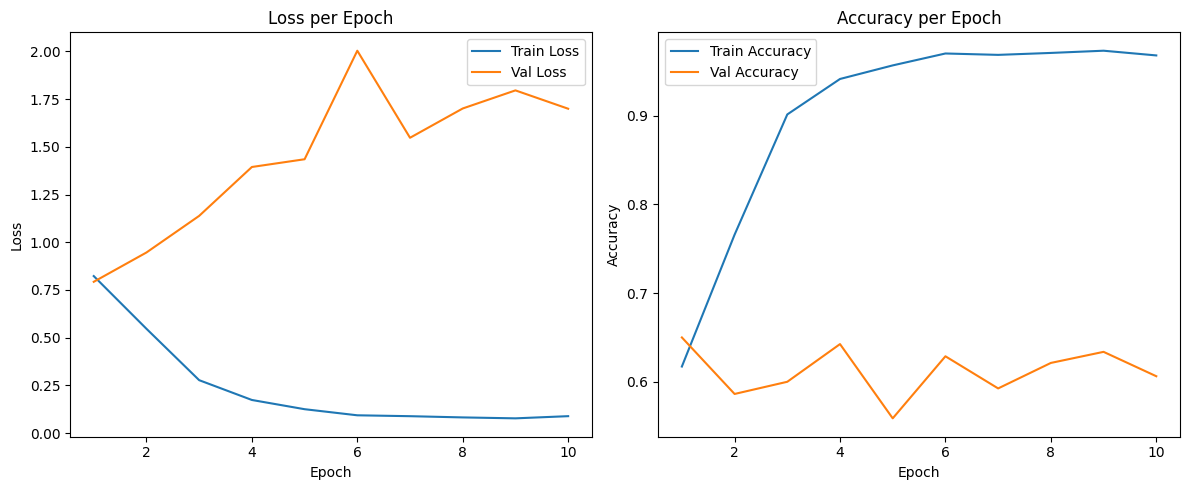

Training Text Only Model:
Epoch 1/10, Loss: 0.8195, Accuracy: 0.6438
Validation Loss: 0.7116, Validation Accuracy: 0.6950
Epoch 2/10, Loss: 0.6447, Accuracy: 0.7444
Validation Loss: 0.7671, Validation Accuracy: 0.6900
Epoch 3/10, Loss: 0.4665, Accuracy: 0.8291
Validation Loss: 0.8229, Validation Accuracy: 0.7037
Epoch 4/10, Loss: 0.2946, Accuracy: 0.9047
Validation Loss: 0.8778, Validation Accuracy: 0.6813
Epoch 5/10, Loss: 0.2191, Accuracy: 0.9306
Validation Loss: 1.0292, Validation Accuracy: 0.6837
Epoch 6/10, Loss: 0.1527, Accuracy: 0.9556
Validation Loss: 1.1674, Validation Accuracy: 0.6488
Epoch 7/10, Loss: 0.1103, Accuracy: 0.9675
Validation Loss: 1.4050, Validation Accuracy: 0.6725
Epoch 8/10, Loss: 0.0871, Accuracy: 0.9738
Validation Loss: 1.6096, Validation Accuracy: 0.6575
Epoch 9/10, Loss: 0.0733, Accuracy: 0.9788
Validation Loss: 1.6195, Validation Accuracy: 0.6425
Epoch 10/10, Loss: 0.1037, Accuracy: 0.9697
Validation Loss: 1.3105, Validation Accuracy: 0.6538


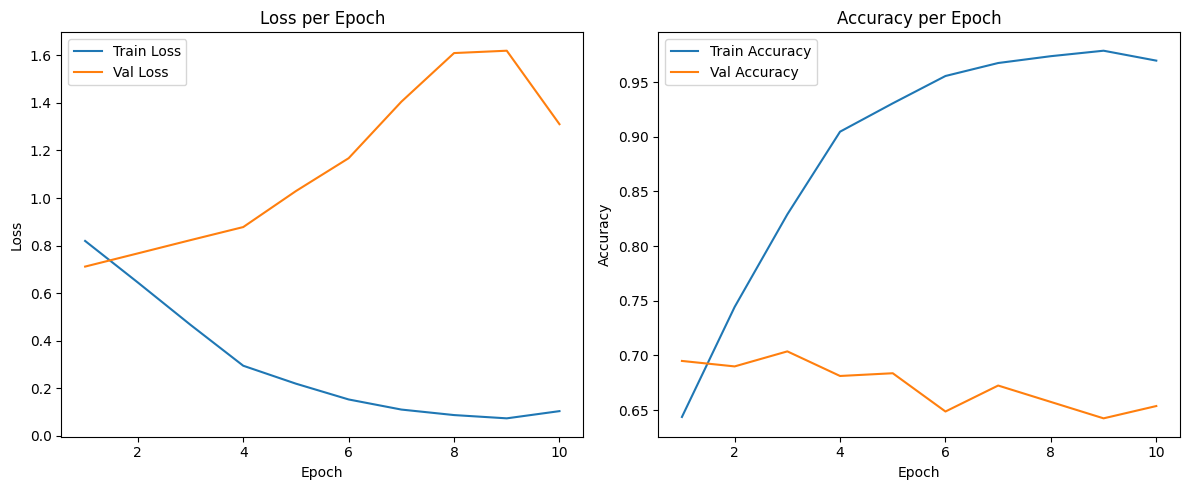

In [17]:
def train_and_evaluate_ablation(model, train_loader, val_loader, optimizer, criterion, num_epochs=10, device='cuda'):
    model.to(device)  # 将模型移动到指定设备
    
    train_losses = []  # 记录训练损失
    train_accuracies = []  # 记录训练准确率
    val_losses = []  # 记录验证损失
    val_accuracies = []  # 记录验证准确率
    
    for epoch in range(num_epochs):
        model.train()  # 设置模型为训练模式
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        
        for batch in train_loader:
            optimizer.zero_grad()
            
            # 获取数据并移动到设备
            images = batch['image'].to(device)
            texts = {key: value.squeeze(1).to(device) for key, value in batch['text'].items()}
            labels = batch['label'].to(device)
            
            # 模型前向传播
            outputs = model(images, texts)
            
            # 计算损失
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # 计算准确率
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
        
        # 计算并记录训练损失和准确率
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct_predictions / total_predictions
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
        
        # 训练后进行验证
        val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)
        
        # 记录验证集损失和准确率
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
    
    # 绘制损失和准确率曲线
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

# 创建消融实验模型实例
image_only_model = ImageOnlyModel(num_classes=3)
text_only_model = TextOnlyModel(num_classes=3)

# 创建优化器
optimizer_image_only = optim.Adam(image_only_model.parameters(), lr=1e-4)
optimizer_text_only = optim.Adam(text_only_model.parameters(), lr=1e-4)

# 训练并评估消融实验模型
print("Training Image Only Model:")
train_and_evaluate_ablation(image_only_model, train_loader, val_loader, optimizer_image_only, criterion, num_epochs=10, device=device)

print("Training Text Only Model:")
train_and_evaluate_ablation(text_only_model, train_loader, val_loader, optimizer_text_only, criterion, num_epochs=10, device=device)
